In [1]:
import scipy
import scanpy
import anndata
import pandas
import numpy
import os
from pathlib import Path
from matplotlib import pyplot, cm
import json
import time

from common import (
    permit_list_loaders,
    load_barcode_list,
)

In [2]:
def scanpy_load_alevin_mtx(analysis_dir, *, force_var_names=None, force_obs_names=None):
    analysis_dir = Path(analysis_dir)
    quant_dir = analysis_dir / "quant" / "alevin"
    alevin = scanpy.read_mtx(quant_dir / "quants_mat.mtx")
    alevin_vars = pandas.read_csv(
        quant_dir / "quants_mat_cols.txt", header=None
    ).set_index(0).index
    alevin_obs = pandas.read_csv(
        quant_dir / "quants_mat_rows.txt", header=None
    ).set_index(0).index

    alevin.obs_names = alevin_obs.values
    alevin.var_names = alevin_vars.values

    if force_var_names is not None:
        alevin_vars = alevin_vars.intersection(force_var_names)
    if force_obs_names is not None:
        alevin_obs = alevin_obs.intersection(force_obs_names)
        
    alevin_df = alevin[alevin_obs,alevin_vars].to_df()
    if force_obs_names is not None:
        alevin_df = alevin_df.reindex(force_obs_names).fillna(0)
    else:
        force_obs_names = alevin_obs.values

    if force_var_names is not None:
        alevin_df = alevin_df.T.reindex(force_var_names).T.fillna(0)
    else:
        force_var_names = alevin_vars.values

    alevin = anndata.AnnData(X=scipy.sparse.csr_matrix(alevin_df))
    alevin.obs_names = force_obs_names
    alevin.var_names = force_var_names

    alevin.obs["counts"] = alevin.X.sum(axis=1)
    alevin.obs["ngenes"] = numpy.array((alevin.X > 0).sum(axis=1))

    return alevin


def scanpy_load_kallisto_gene_mtx(analysis_dir, *, force_var_names=None, force_obs_names=None):
    analysis_dir = Path(analysis_dir) / "count"
    kallisto = scanpy.read_mtx(analysis_dir / "output.mtx")
    kallisto_vars = pandas.read_csv(
        analysis_dir / "output.genes.txt", header=None
    ).set_index(0).index
    kallisto_obs = pandas.read_csv(
        analysis_dir / "output.barcodes.txt", header=None
    ).set_index(0).index
    kallisto.obs_names = kallisto_obs.values
    kallisto.var_names = kallisto_vars.values

    if force_var_names is not None:
        kallisto_vars = kallisto_vars.intersection(force_var_names)
    if force_obs_names is not None:
        kallisto_obs = kallisto_obs.intersection(force_obs_names)
        
    kallisto_df = kallisto[kallisto_obs,kallisto_vars].to_df()    
    if force_obs_names is not None:
        kallisto_df = kallisto_df.reindex(force_obs_names).fillna(0)
    else:
        force_obs_names = kallisto_obs.values

    if force_var_names is not None:
        kallisto_df = kallisto_df.T.reindex(force_var_names).T.fillna(0)
    else:
        force_var_names = kallisto_vars.values

    kallisto = anndata.AnnData(X=scipy.sparse.csr_matrix(kallisto_df))
    kallisto.obs_names = force_obs_names
    kallisto.var_names = force_var_names

    kallisto.obs["counts"] = kallisto.X.sum(axis=1)
    kallisto.obs["ngenes"] = numpy.array((kallisto.X > 0).sum(axis=1))

    return kallisto


In [3]:
def sc_scatter(table, correlations, name_x, name_y, cell_id, threshold=0.8, ax=None):
    #fontname = 'Arial'
    fontname = 'DejaVu Sans'
    fontsize = 14
    gridalpha = 0.5
    def is_spike(x):
        if x.startswith('gSpikein_') or x.startswith('tSpikein_'):
            return True
        else:
            return False

    if ax is None:
        f = pyplot.figure()
        ax = f.subplots(1,1)
    
    #x_cells = numpy.asarray(table[name_x][cell_id].X.todense())
    #y_cells = numpy.asarray(table[name_y][cell_id].X.todense())
    left = table[name_x][cell_id].to_df().T
    right = table[name_y][cell_id].to_df().T
    counts = left.merge(right, left_index=True, right_index=True, how='inner')
    left_name = cell_id + "_x"
    right_name = cell_id + "_y"
    
    rel_diff = numpy.abs(counts[left_name]-counts[right_name])/(counts.max(axis=1)+1)
    
    set1 = cm.get_cmap('Set1').colors
    colors = [{True: set1[0], False: set1[1]}[x] for x in (rel_diff > threshold).values]
    
    #counts.plot.scatter(x=cell_id+"_x", y=cell_id+"_y", ax=ax, s=2)
    ax.scatter(counts[left_name], counts[right_name], c=colors, s=2)
    b = 6
    lim = numpy.arange(0.1, counts.max().max(), 0.1)
    lim_up = lim + b
    lim_down = lim -b
    ax.plot(lim, lim, c=set1[2])
    ax.plot(lim, lim_up, c=set1[0])
    ax.plot(lim, lim_down, c=set1[0])
    ax.set_xlim((.1, counts.max().max()))
    ax.set_ylim((.1, counts.max().max()))
    #ax.scatter(table[name_x][cell_id].X.todense()+0.01, table[name_y][cell_id].X.todense()+0.01, s=2)
    spearman = correlations[(name_x, name_y)][cell_id]
    gene_count = counts[counts > 0].count().max()
    ax.set_title(f'id {cell_id}\n{spearman:0.4}\nGenes: {gene_count}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(name_x, fontsize=fontsize, fontfamily=fontname)
    ax.set_ylabel(name_y, fontsize=fontsize, fontfamily=fontname)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)

    
def show_scatter_cells(dense_mat, correlations, name_x, name_y, cells, threshold=0.8):
    f = pyplot.figure(figsize=(12,4))
    #f.suptitle(f'{metric} worst, median and best cells')
    axes = f.subplots(1, len(cells), sharex=True, sharey=True)
    for ax, cell in zip(axes, cells):
        sc_scatter(dense_mat, correlations, name_x, name_y, cell, threshold=threshold, ax=ax)
    return f    

def show_scatter_extremes(dense_mat, correlations, name_x, name_y, threshold=0.8):
    scores = correlations[(name_x, name_y)]
    best_cell = scores.idxmax()
    worst_cell = scores.idxmin()
    # find smallest absolute difference from median and use that as median cell
    median = numpy.abs(scores - scores.median())
    median_cell = median.idxmin()
    #print(best_cell, worst_cell, median_cell)
    cells = [worst_cell, median_cell, best_cell]
    show_scatter_cells(dense_mat, correlations, name_x, name_y, cells, threshold)


In [4]:
count_loaders = {
    #'alevin_out': scanpy_load_alevin_mtx,
    'alevin_out_transcriptome': scanpy_load_alevin_mtx,
    'kallisto_out': scanpy_load_kallisto_gene_mtx,
    'kallisto_bus_em_out': scanpy_load_kallisto_gene_mtx,
}

In [5]:
search_path = [Path('~/BP_2021/data').expanduser(), Path('~/BP_comparison/data').expanduser()]
analysis_root = {
    #'alevin_out': Path('~/BP_2021/data/alevin_out').expanduser(),
    'alevin_out_transcriptome': Path('~/BP_comparison/data/alevin_out_transcriptome').expanduser(),
    'kallisto_out': Path('~/BP_2021/data/kallisto_out').expanduser(),
    'kallisto_bus_em_out': Path('~/BP_comparison/data/kallisto_bus_em_out').expanduser(),
}

In [6]:
with open('data/datasets.json', 'rt') as instream:
    datasets = json.load(instream)

In [7]:
def plot_sample_correlation_scatter_plots(dataset_name, set_mode, threshold=0.8):
    counts = {}

    #barcodes = permit_list_loaders[algorithm_name](search_path, dataset_name)
    barcode_pathname = Path('data/common_barcodes/{}.{}.txt'.format(dataset_name, set_mode))
    barcodes = load_barcode_list(barcode_pathname)
    for algorithm_name in count_loaders:
        analysis_dir = analysis_root[algorithm_name] / dataset_name
        counts[algorithm_name] = count_loaders[algorithm_name](analysis_dir, force_obs_names=barcodes)

    correlations = pandas.read_csv(
        Path('data/correlations_no_decoy/{}.{}.tsv'.format(dataset_name, set_mode)),
        sep='\t',
        header=[0,1],
        index_col=0,
    )
    for pair in correlations.columns:
        show_scatter_extremes(counts, correlations, pair[0], pair[1], threshold)


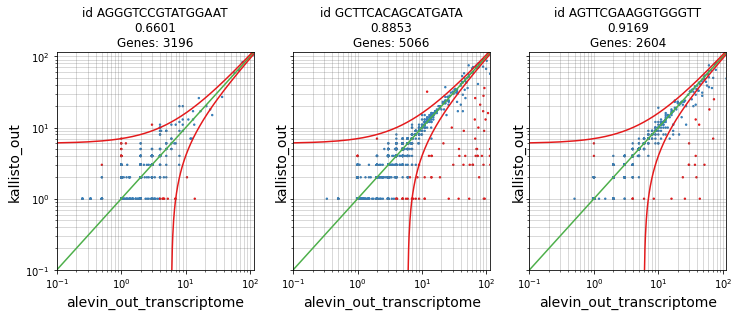

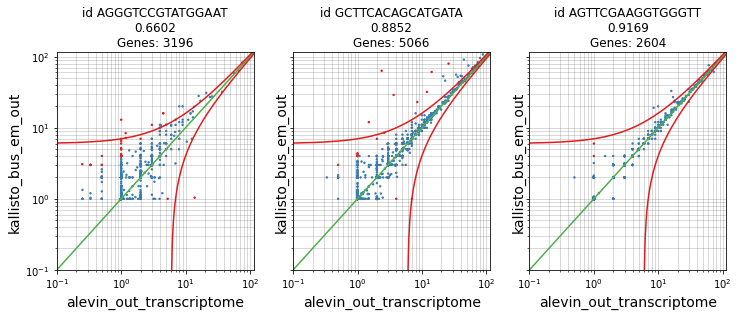

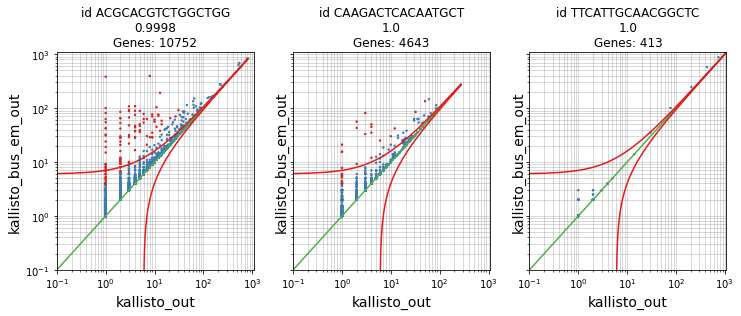

In [8]:
plot_sample_correlation_scatter_plots('human_mouse-hgmm1k_v3', 'intersection', threshold=0.6)

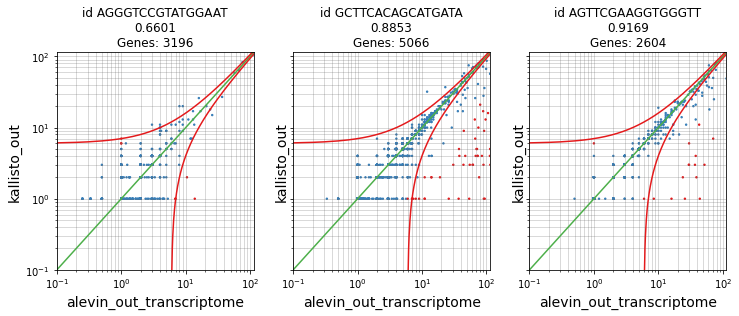

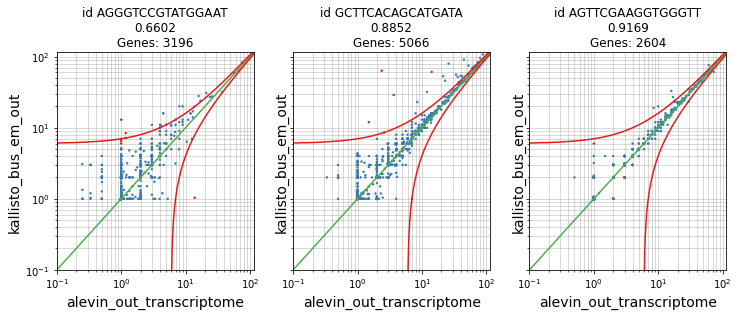

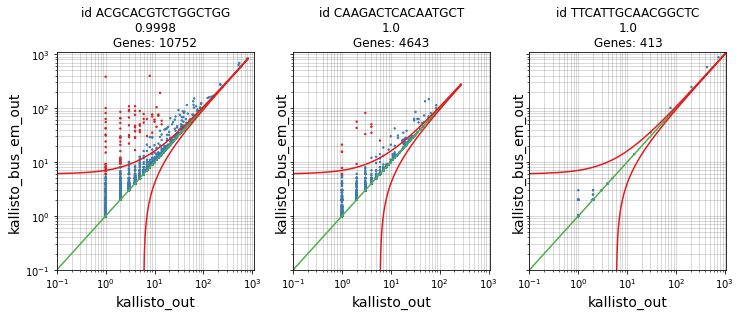

In [9]:
plot_sample_correlation_scatter_plots('human_mouse-hgmm1k_v3', 'intersection', threshold=0.7)

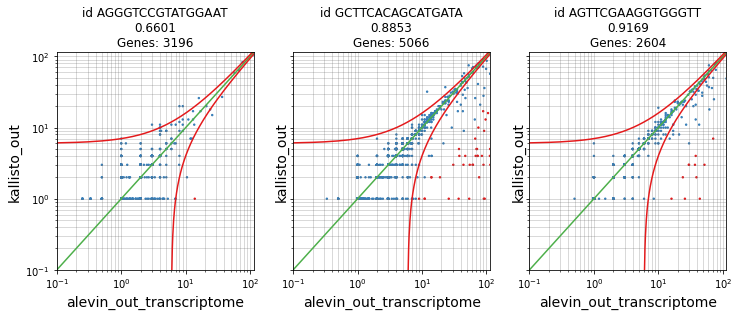

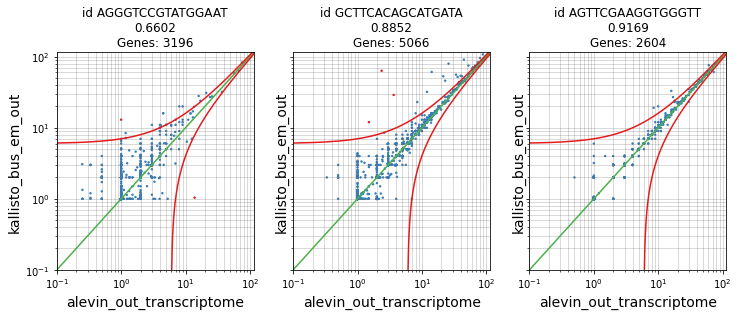

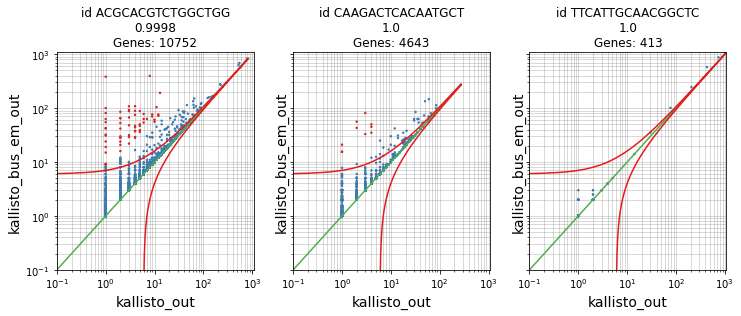

In [10]:
plot_sample_correlation_scatter_plots('human_mouse-hgmm1k_v3', 'intersection', threshold=0.8)

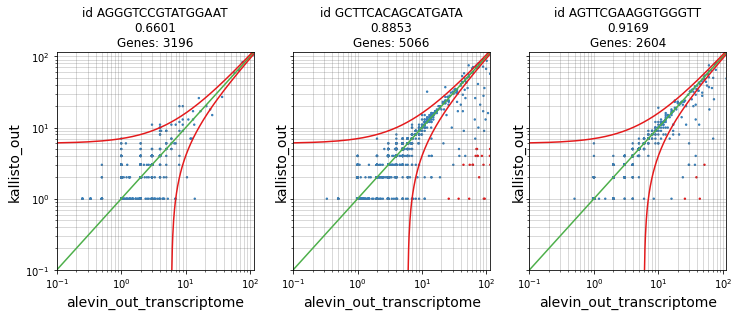

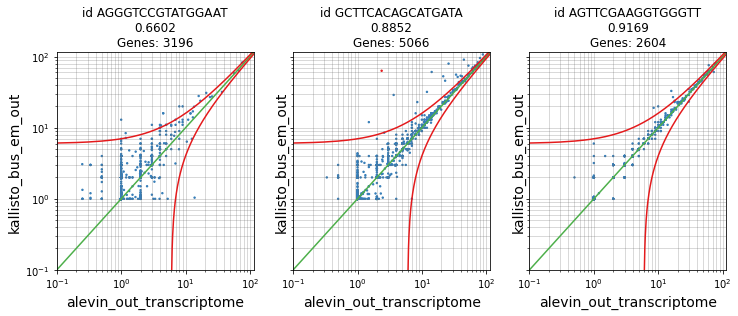

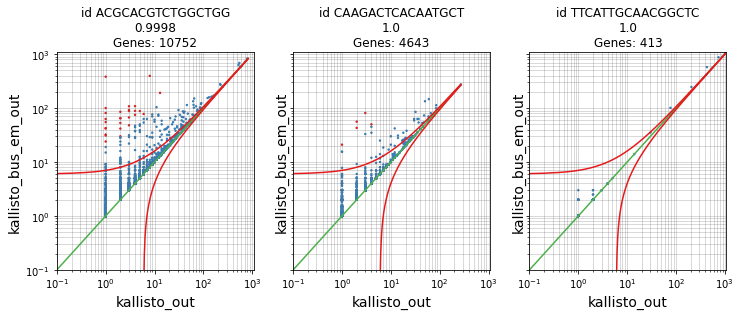

In [11]:
plot_sample_correlation_scatter_plots('human_mouse-hgmm1k_v3', 'intersection', threshold=0.9)

The red lines are $y = x \pm 6$

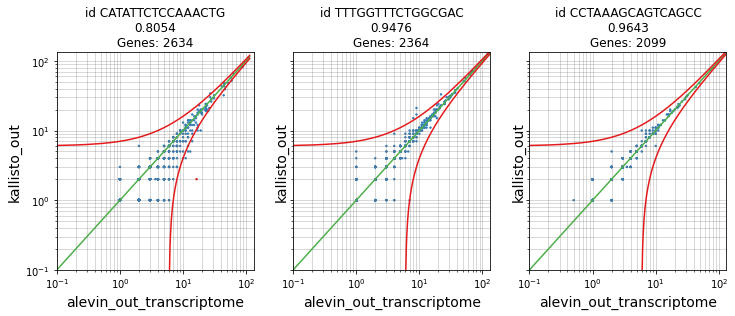

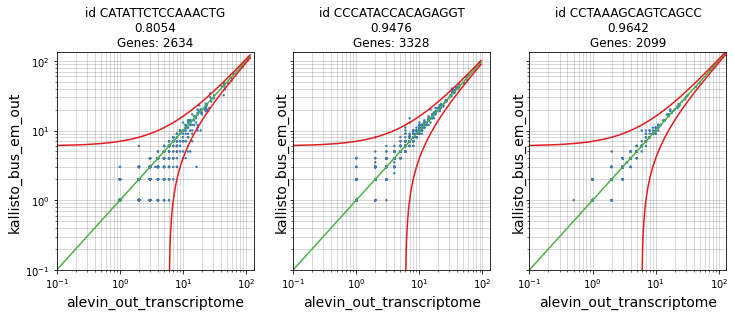

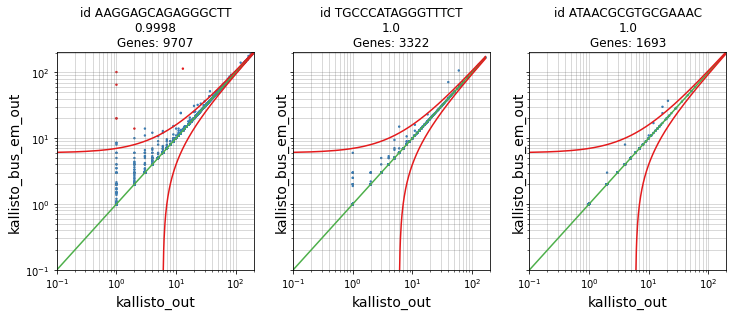

In [12]:
plot_sample_correlation_scatter_plots('arabidopsis-SRR8257100_v2', 'intersection')

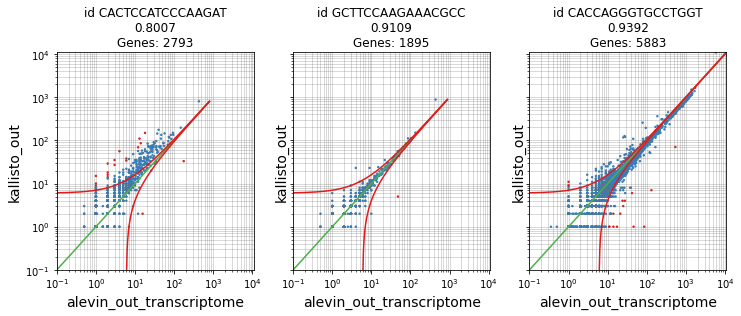

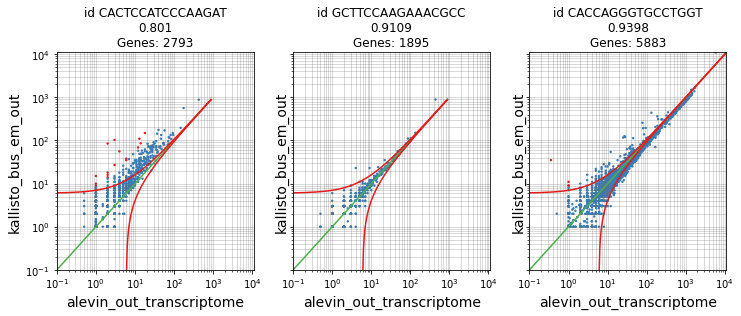

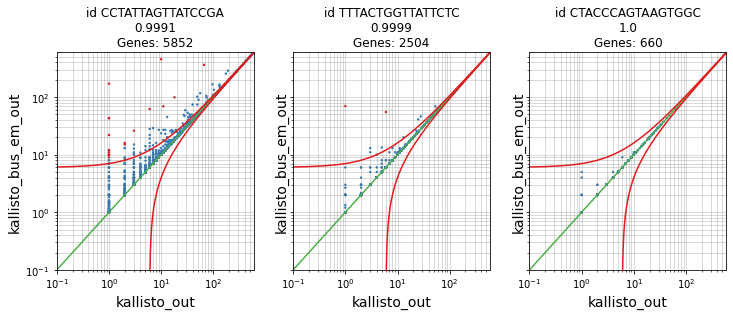

In [13]:
plot_sample_correlation_scatter_plots('fly-SRR8513910_v2', 'intersection')

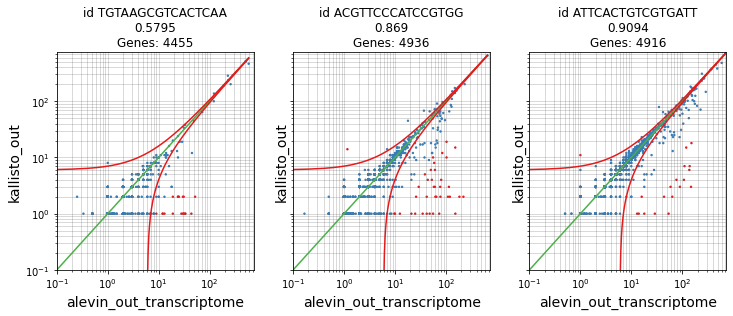

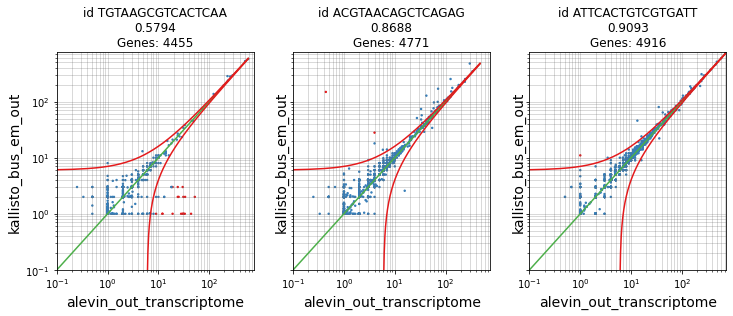

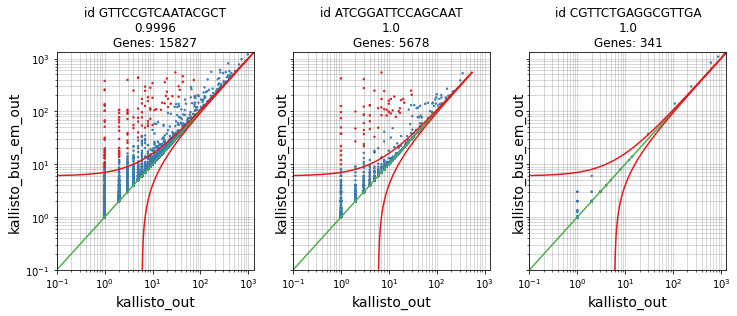

In [14]:
plot_sample_correlation_scatter_plots('human_mouse-hgmm10k_v3', 'intersection')

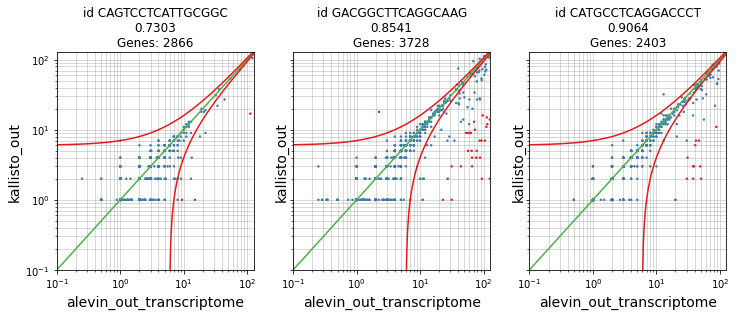

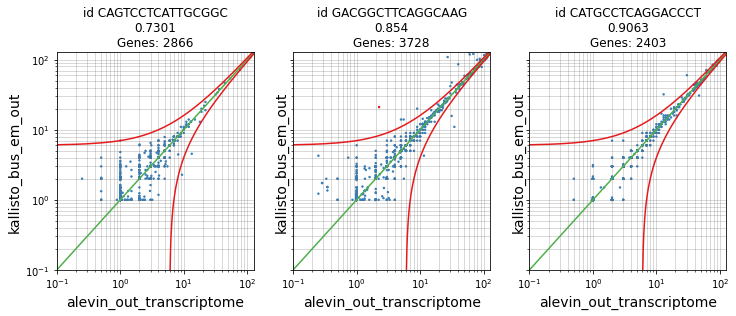

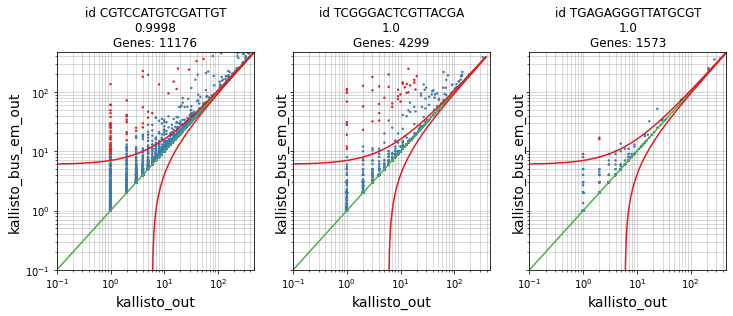

In [15]:
plot_sample_correlation_scatter_plots('human_mouse-hgmm1k_v2', 'intersection')

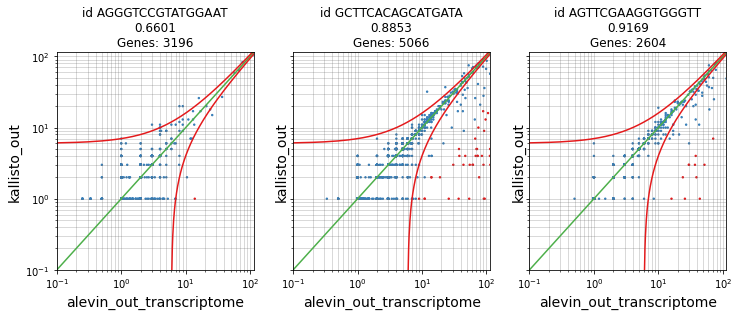

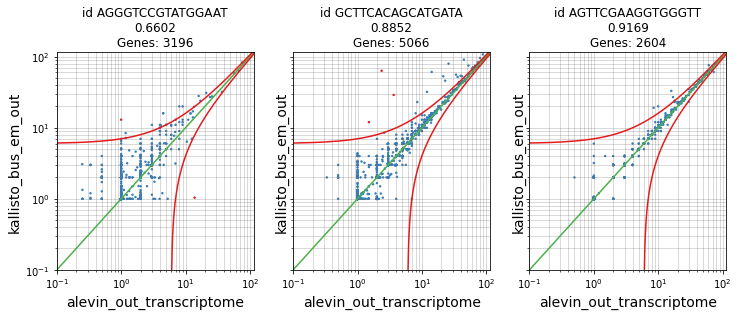

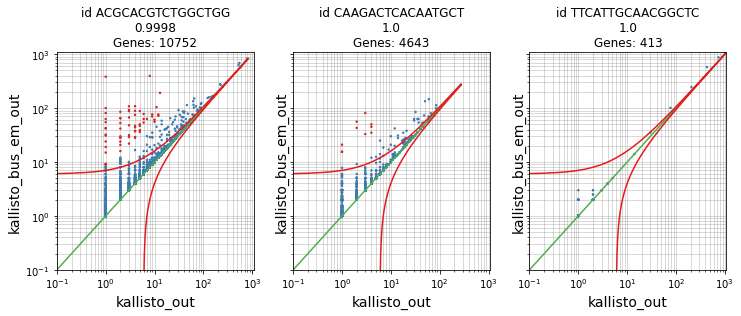

In [16]:
plot_sample_correlation_scatter_plots('human_mouse-hgmm1k_v3', 'intersection')

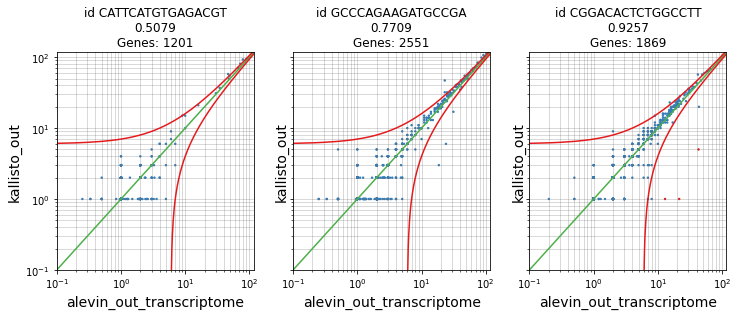

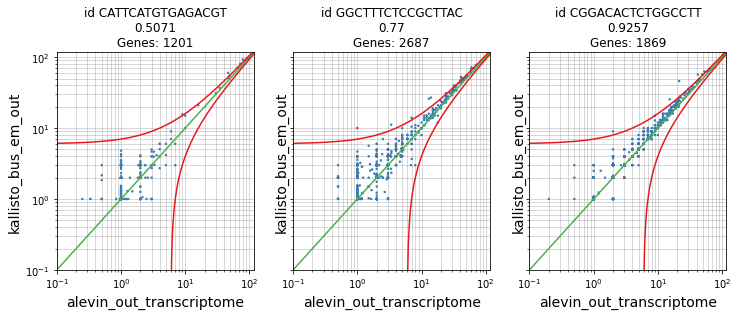

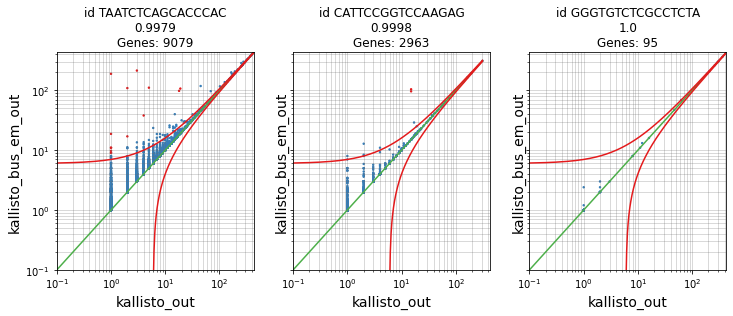

In [17]:
plot_sample_correlation_scatter_plots('human-pbmc10k_v3', 'intersection')

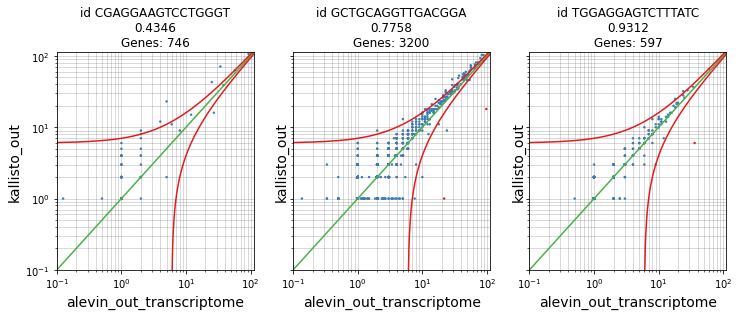

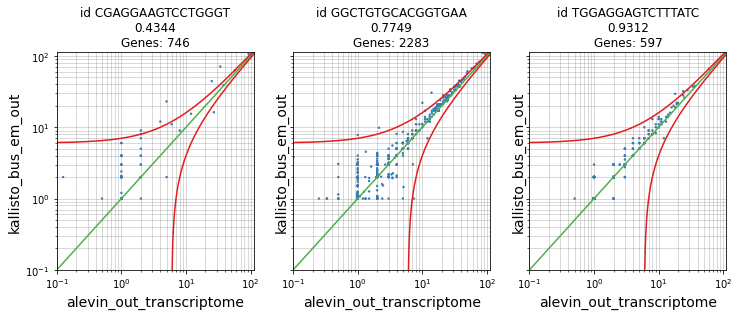

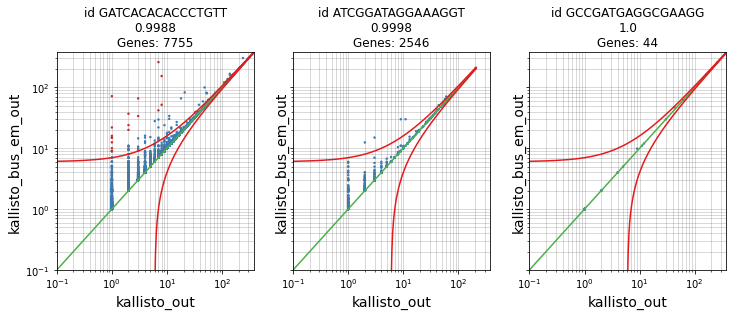

In [18]:
plot_sample_correlation_scatter_plots('human-pbmc1k_v3', 'intersection')

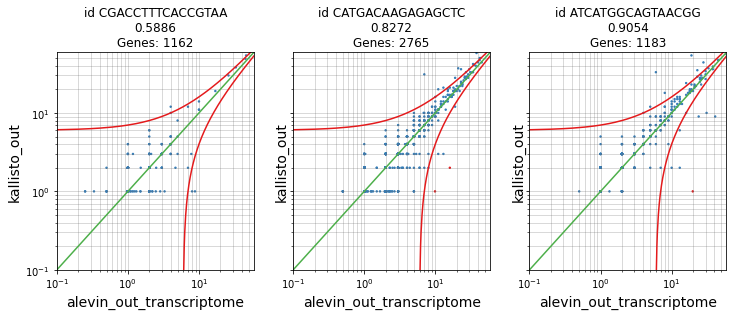

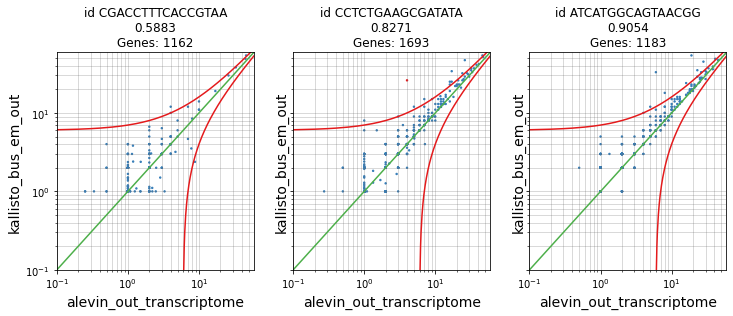

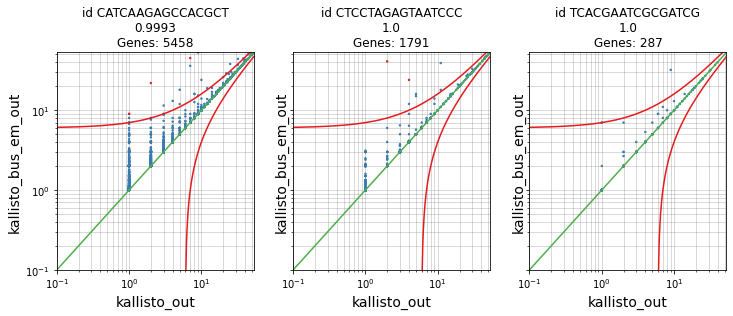

In [19]:
plot_sample_correlation_scatter_plots('human-SRR8327928_v2', 'intersection')

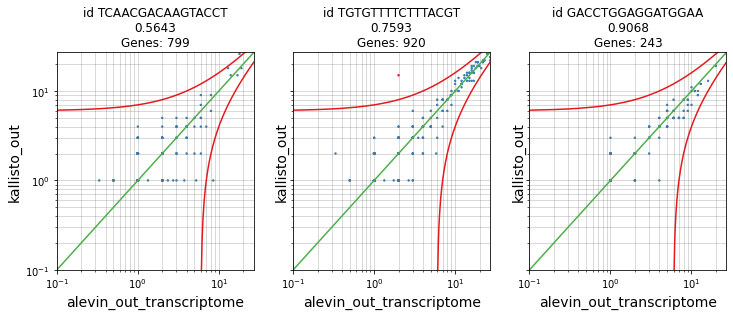

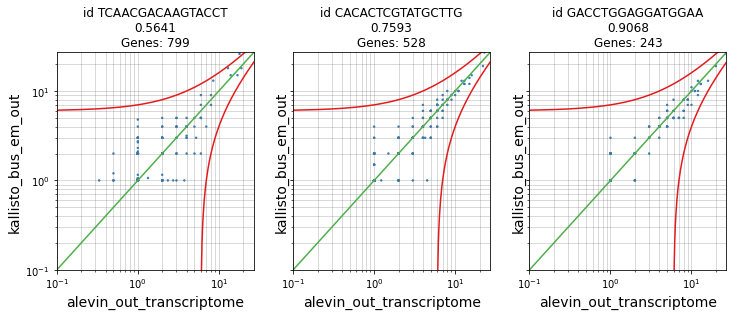

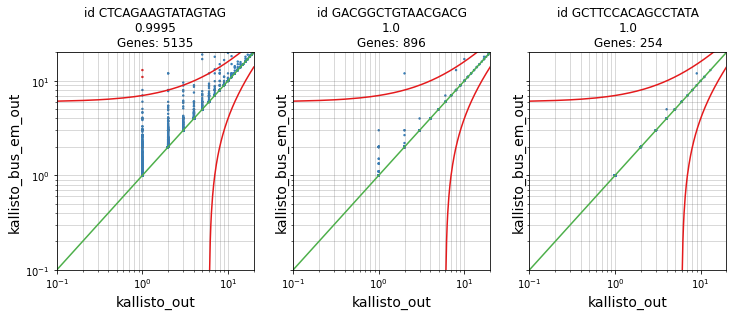

In [20]:
plot_sample_correlation_scatter_plots('human-SRR8524760_v2', 'intersection')

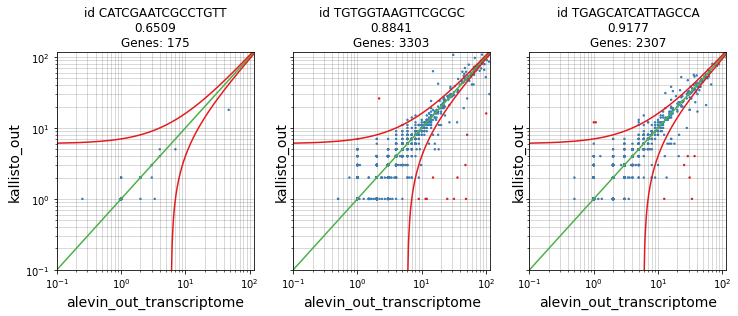

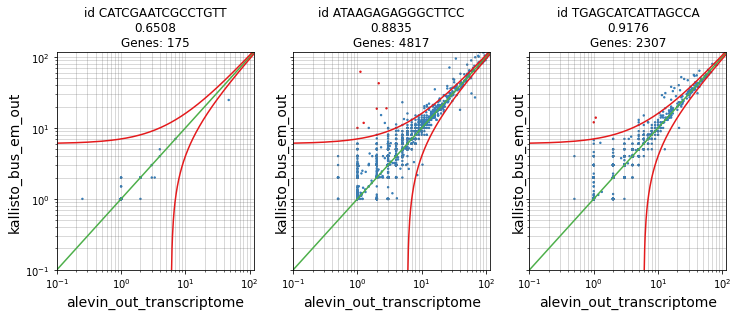

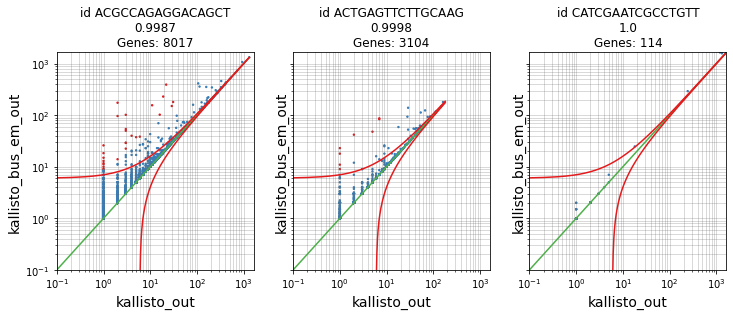

In [21]:
plot_sample_correlation_scatter_plots('mouse-EMTAB7320_v2', 'intersection')

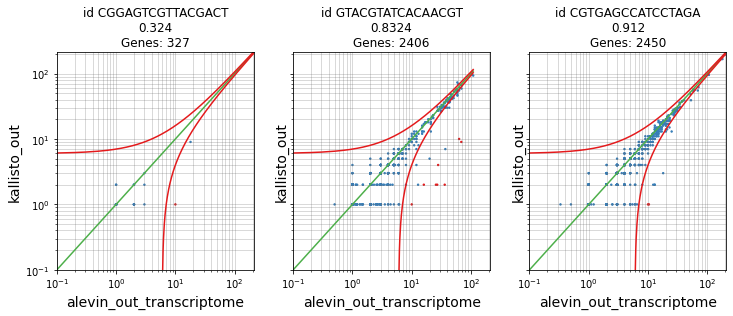

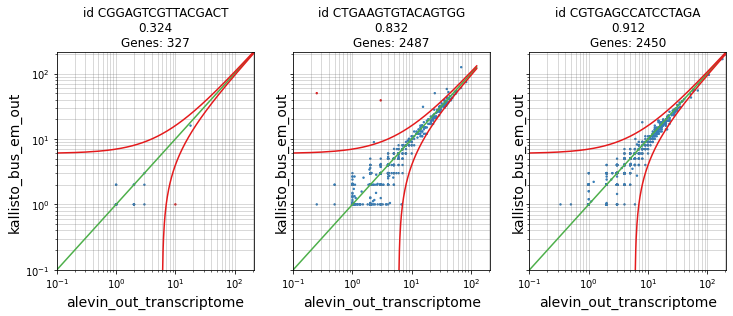

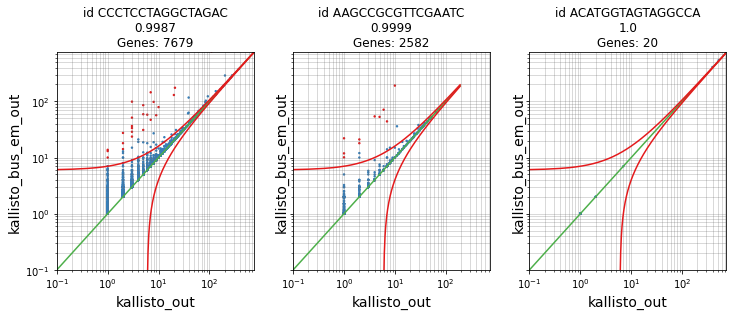

In [22]:
plot_sample_correlation_scatter_plots('mouse-heart1k_v2', 'intersection')

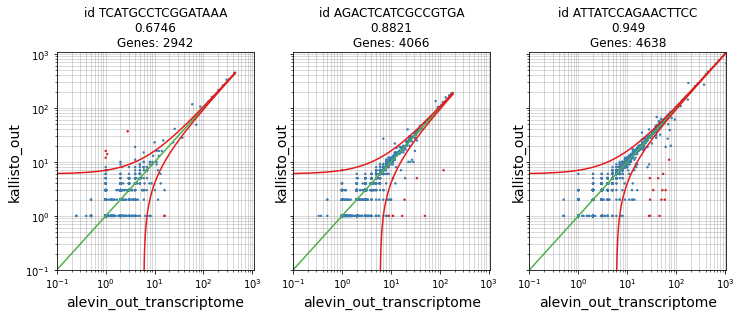

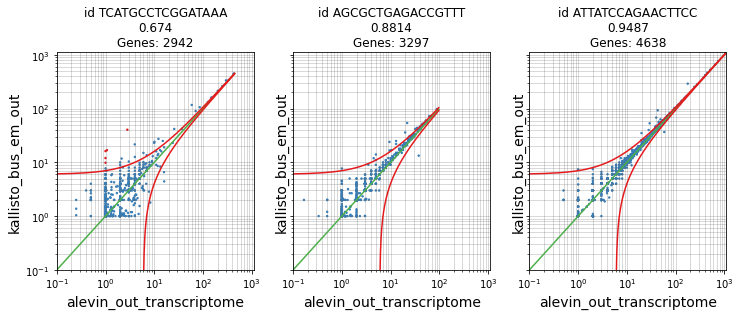

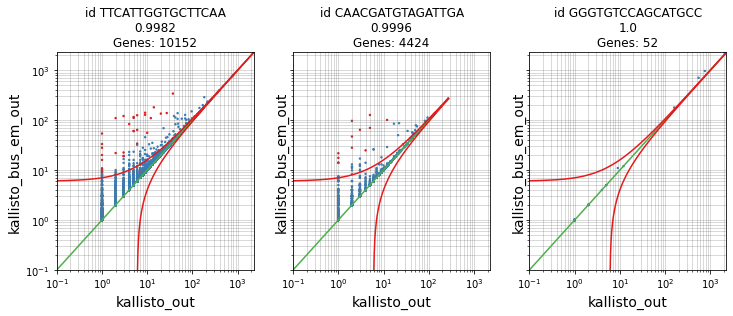

In [23]:
plot_sample_correlation_scatter_plots('mouse-heart1k_v3', 'intersection')

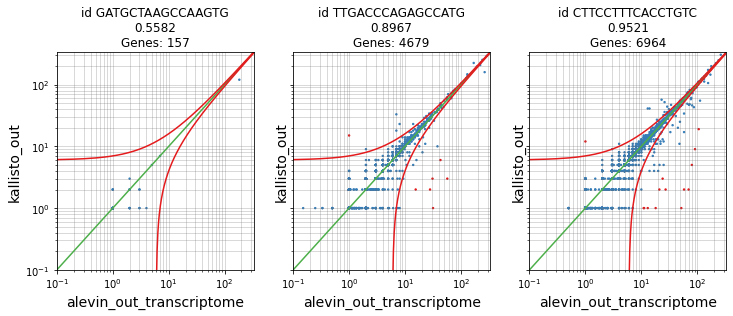

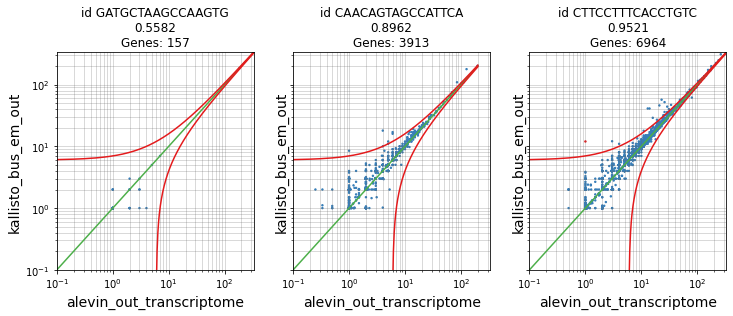

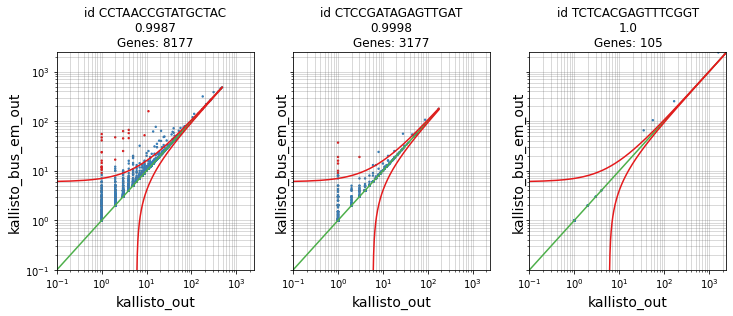

In [24]:
plot_sample_correlation_scatter_plots('mouse-neuron10k_v3', 'intersection')

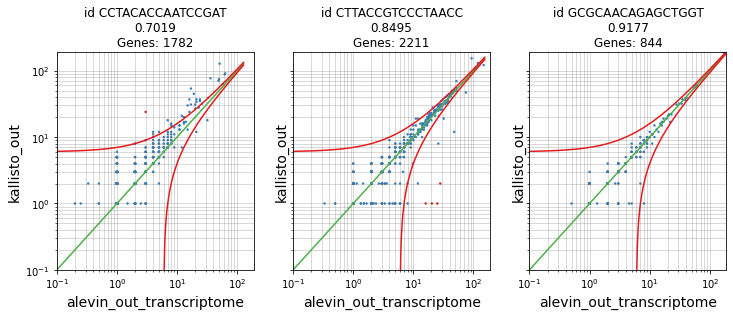

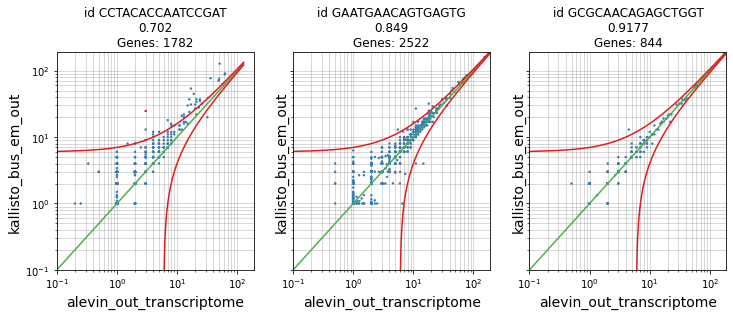

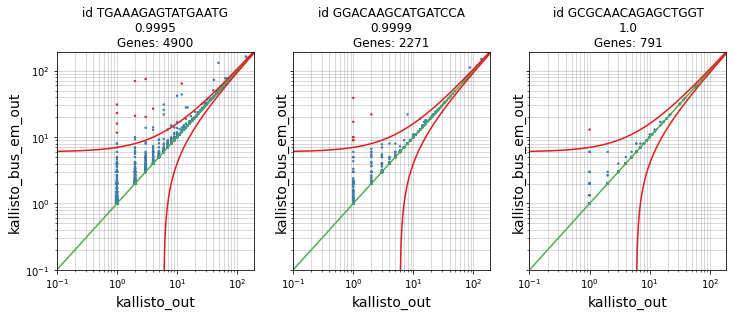

In [25]:
plot_sample_correlation_scatter_plots('mouse-SRR6998058_v2', 'intersection')

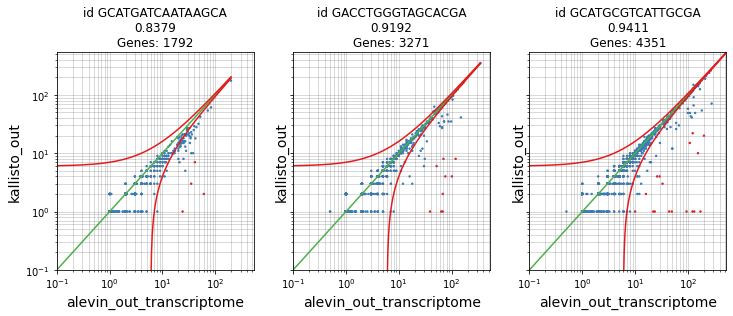

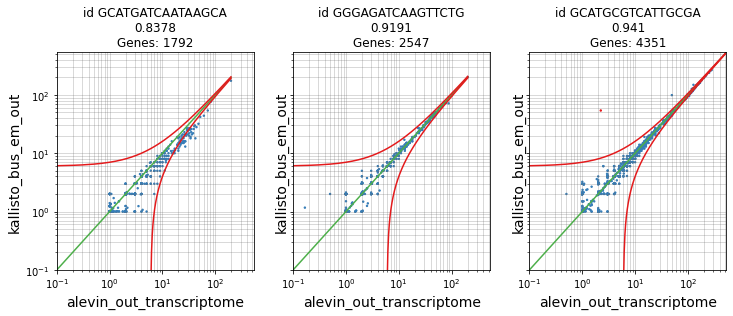

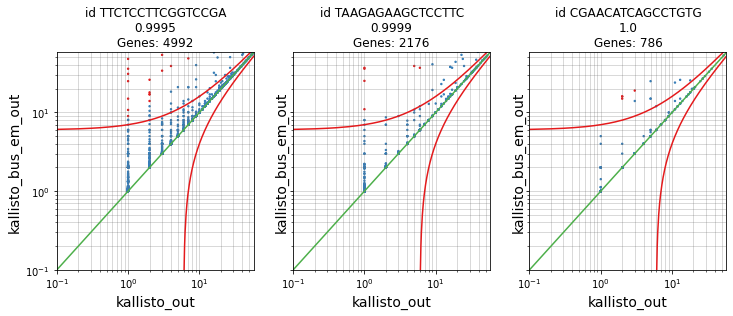

In [26]:
plot_sample_correlation_scatter_plots('mouse-SRR8206317_v2', 'intersection')

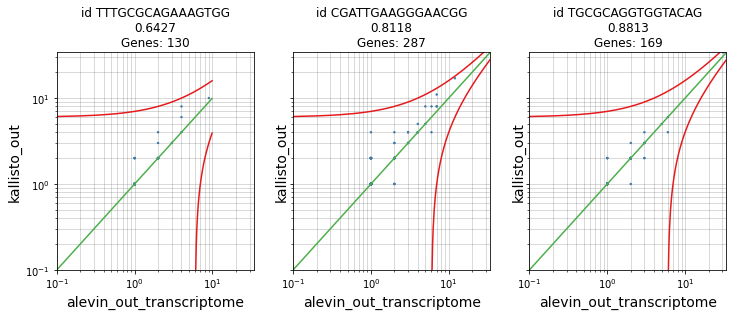

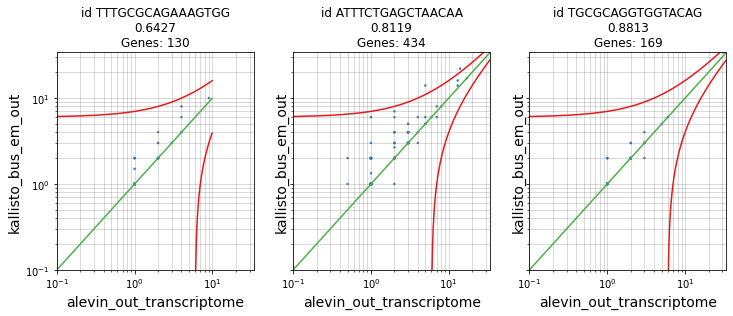

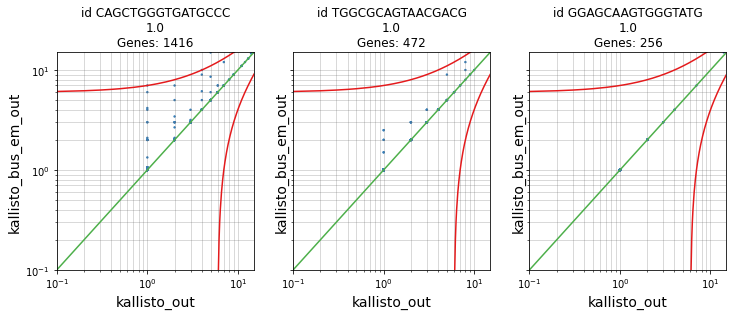

In [27]:
plot_sample_correlation_scatter_plots('mouse-SRR8599150_v2', 'intersection')

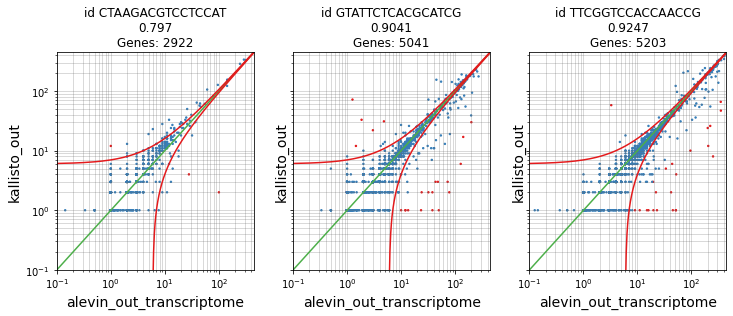

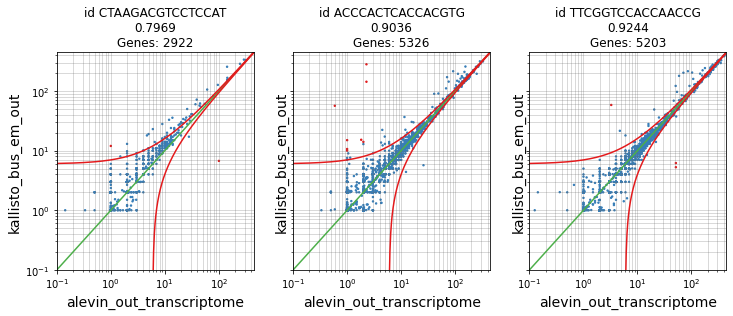

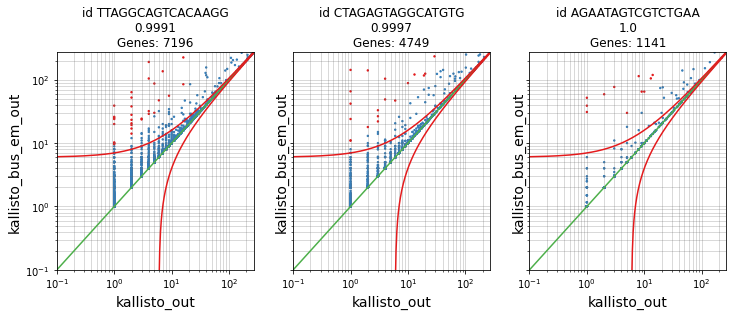

In [28]:
plot_sample_correlation_scatter_plots('mouse-SRR8639063_v2', 'intersection')

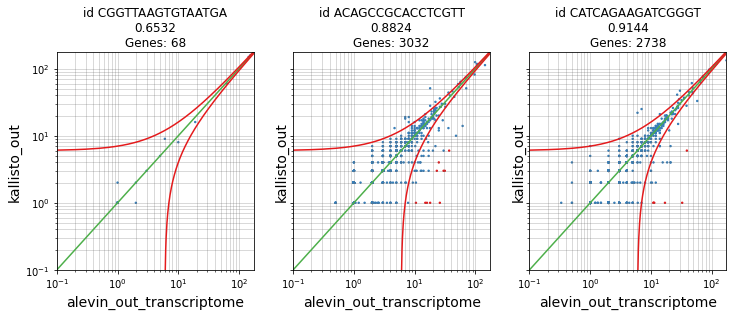

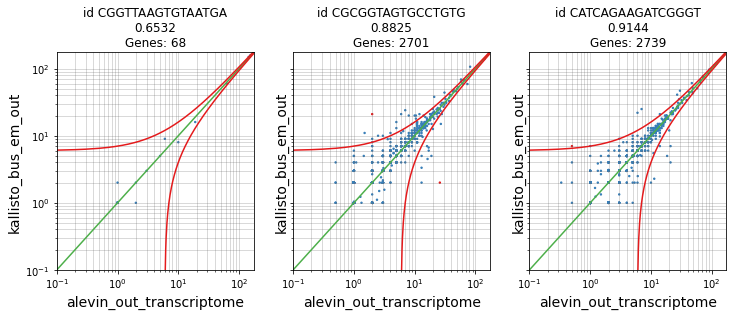

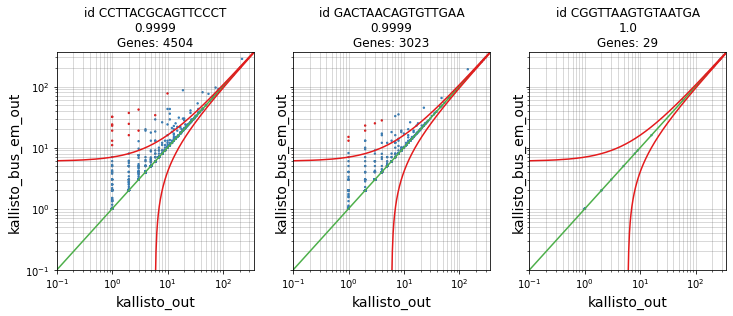

In [29]:
plot_sample_correlation_scatter_plots('rat-SRR7299563_v2', 'intersection')

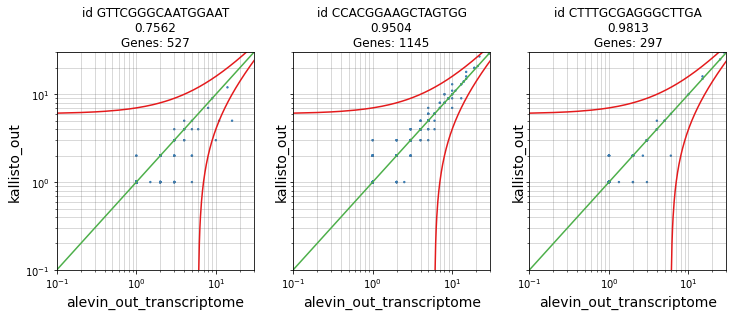

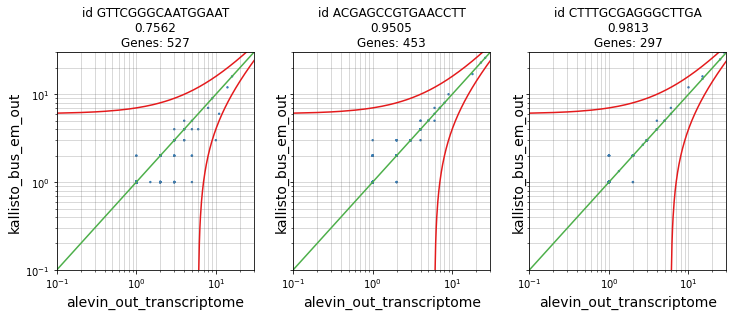

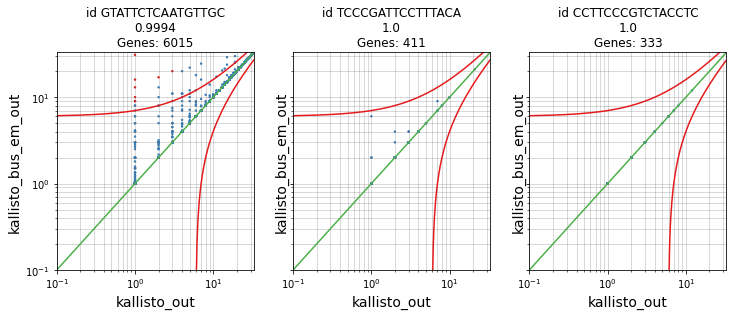

In [30]:
plot_sample_correlation_scatter_plots('worm-SRR8611943_v2', 'intersection')

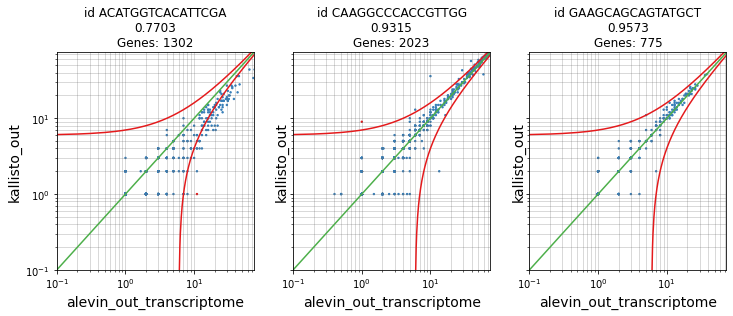

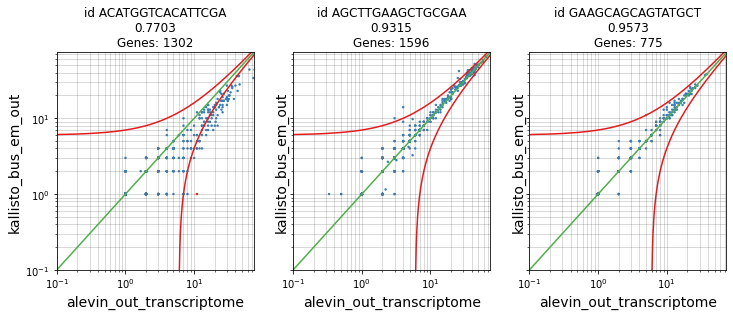

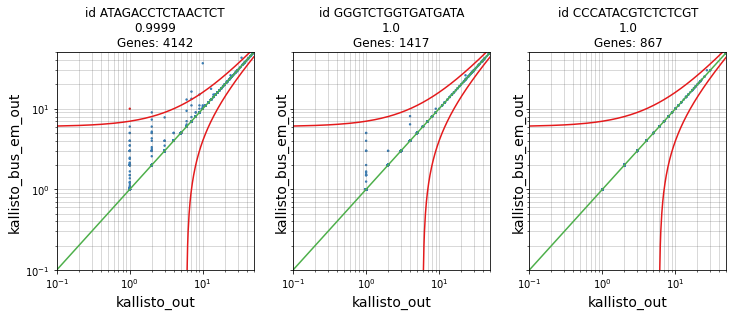

In [31]:
plot_sample_correlation_scatter_plots('zebrafish-SRR6956073_v2', 'intersection')